/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 1 time: 21
episode: 2 time: 11
episode: 3 time: 21
episode: 4 time: 38
episode: 5 time: 23
episode: 6 time: 23
episode: 7 time: 24
episode: 8 time: 32
episode: 9 time: 20
episode: 10 time: 45
episode: 11 time: 95
episode: 12 time: 116
episode: 13 time: 46
episode: 14 time: 89
episode: 15 time: 69
episode: 16 time: 133
episode: 17 time: 111
episode: 18 time: 86
episode: 19 time: 125
episode: 20 time: 148


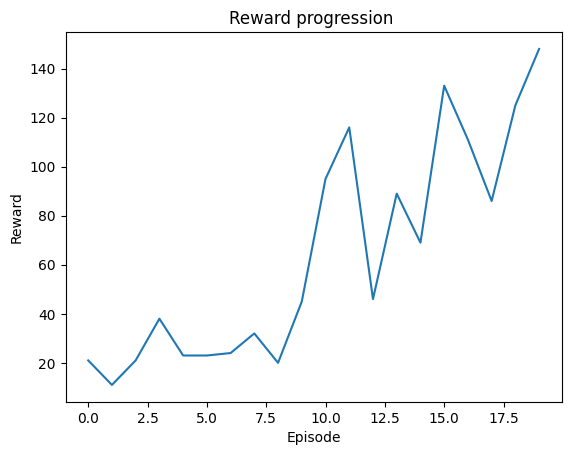

In [2]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import AdamW
import gym
import itertools
from matplotlib import pyplot as plt


def argmax(x):
    ''' Own variant of np.argmax with random tie breaking, function of assignment 1  '''
    try:
        return np.random.choice(np.where(x == np.max(x))[0])
    except:
        return np.argmax(x)


def softmax(x, temp):
    ''' Computes the softmax of vector x with temperature parameter 'temp', function of assignment 1 '''
    x = x / temp  # scale by temperature
    z = x - max(x)  # substract max to prevent overflow of softmax
    return np.exp(z) / np.sum(np.exp(z))  # compute softmax


class DQAgent:
    def __init__(self, state_size, action_size, replay_memory_capacity=1000, epsilon=0.5, target=True, replay=True):
        self.state_size = state_size  # Set output size for Q-function
        self.action_size = action_size  # Set input size for Q-function
        self.memory = deque(maxlen=replay_memory_capacity)  # Initialize replay memory to capacity N
        self.gamma = 0.95  # Future rewards are discounted by gamma per time-step
        self.learning_rate = 0.001  # Learning rate for gradient descent
        self.Q_network = self._build_model()  # Initialize action-value function Q with random weights
        self.Q_network_target = self._build_model()
        self.epsilon = epsilon  # Probability for random action
        self.epsilon_min = 0.01
        self.episodes_max = 20
        self.target = target  # If True predictions are made using an alternate network that undergoes periodic updates
        self.use_replay = replay # If True experience replay will be used

    def _build_model(self):  # Takes state as input, outputs Q values for legal actions
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=AdamW(learning_rate=self.learning_rate), metrics=['accuracy'])
        return model

    def store_transition(self, s, a, r, s_next, done):  # Stores transition in replay memory
        self.memory.append((s, a, r, s_next, done))

    def Q_value_predict(self, s):
        if self.target:
            return self.Q_network_target.predict(s, verbose=0)
        else:
            return self.Q_network.predict(s, verbose=0)

    def replay(self, batch_size):
        if self.use_replay:
            minibatch = random.sample(self.memory, batch_size)  # if experience replay is used experiences are randomly sampled from memory
        else:
            index = len(self.memory) - batch_size
            minibatch = list(itertools.islice(self.memory, index, None))  # if experience replay is not used the model is trained on the last experiences

        for s, a, r, s_next, done in minibatch:
            if done:
                y = r
            else:
                Q_next = np.amax(self.Q_value_predict(s_next)[0])
                y = r + self.gamma * Q_next
            Q = self.Q_value_predict(s)
            Q[0][a] = y
            self.Q_network.fit(s, Q, verbose=0)  # Keras builds the loss function akin to equation 3 as outlined in the DQN paper.

    def select_action(self, s, current_episode, method="anneal_epsilon"):
        random_action = env.action_space.sample() # Random action
        Q_values = self.Q_network.predict(s, verbose=0)  # Get Q-values from Q-function
        greedy_action = np.argmax(Q_values[0])  # action associated with the maximum Q-value
        if method == "egreedy":
            if self.epsilon >= np.random.rand():
                return random_action
            else:
                return greedy_action
        elif method == "anneal_epsilon":
            self.linear_annealing_epsilon(current_episode)
            if self.epsilon >= np.random.rand():
                return random_action
            else:
                return greedy_action
        elif method == "boltzmann":
            return argmax(softmax(Q_values, self.epsilon))

    def update_target_network(self):
        self.Q_network_target.set_weights(self.Q_network.get_weights())

    def linear_annealing_epsilon(self, current_episode):
        """Linear function decay of epsilon parameter """
        gradient_epsilon = (self.epsilon_min - 1.0) / self.episodes_max
        self.epsilon = gradient_epsilon * current_episode + 1.0


if __name__ == "__main__":

    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQAgent(state_size, action_size, replay=True)
    episodes = agent.episodes_max
    batch_size = 16
    rewards = []

    for e in range(episodes):
        s= env.reset()
        s = np.array([s]).reshape([1, state_size])
        done = False
        time = 0
        while not done or time >= 500: # The maximum of the environment is 500
            a = agent.select_action(s, e, "anneal_epsilon")
            step_result = env.step(a)  # Execute action_t in emulator and observe next_state, reward and terminal state
            s_next, r, done, _ = step_result[:4]
            s_next = np.reshape(s_next, [1, state_size])
            agent.store_transition(s, a, r, s_next, done)

            if len(agent.memory) >= batch_size:  # Only perform experience replay once memory is full
                agent.replay(batch_size)

            s = s_next
            time += 1
            if time % 10 == 0 and agent.target:
                agent.update_target_network()

        print('episode:', e + 1, 'time:', time)
        rewards.append(time)
    plt.plot(rewards)
    plt.title("Reward progression ")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
    env.close()


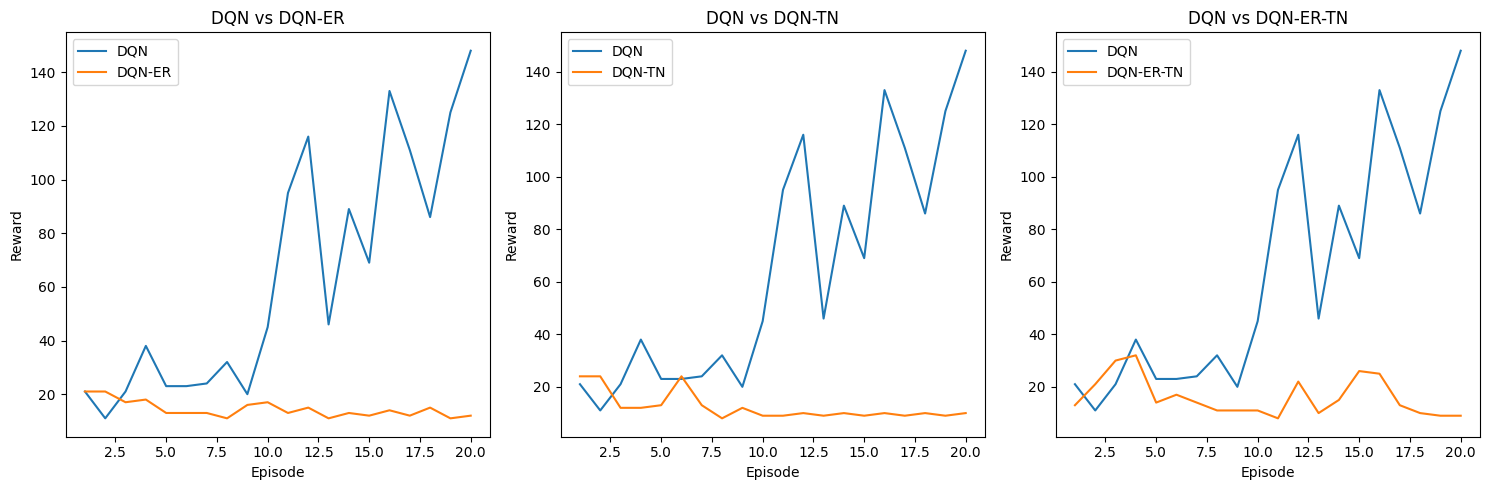

In [4]:
import matplotlib.pyplot as plt

# Episode times for each variant
dqn_times = [21, 11, 21, 38, 23, 23, 24, 32, 20, 45, 95, 116, 46, 89, 69, 133, 111, 86, 125, 148]
dqn_er_times = [21, 21, 17, 18, 13, 13, 13, 11, 16, 17, 13, 15, 11, 13, 12, 14, 12, 15, 11, 12]
dqn_tn_times = [24, 24, 12, 12, 13, 24, 13, 8, 12, 9, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10]
dqn_er_tn_times = [13, 21, 30, 32, 14, 17, 14, 11, 11, 11, 8, 22, 10, 15, 26, 25, 13, 10, 9, 9]

# Episode numbers
episodes = list(range(1, 21))

# Plotting
plt.figure(figsize=(15, 5))

# Compare DQN with DQN−ER
plt.subplot(1, 3, 1)
plt.plot(episodes, dqn_times, label='DQN')
plt.plot(episodes, dqn_er_times, label='DQN-ER')
plt.title('DQN vs DQN-ER')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# Compare DQN with DQN−TN
plt.subplot(1, 3, 2)
plt.plot(episodes, dqn_times, label='DQN')
plt.plot(episodes, dqn_tn_times, label='DQN-TN')
plt.title('DQN vs DQN-TN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# Compare DQN with DQN−ER−TN
plt.subplot(1, 3, 3)
plt.plot(episodes, dqn_times, label='DQN')
plt.plot(episodes, dqn_er_tn_times, label='DQN-ER-TN')
plt.title('DQN vs DQN-ER-TN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()

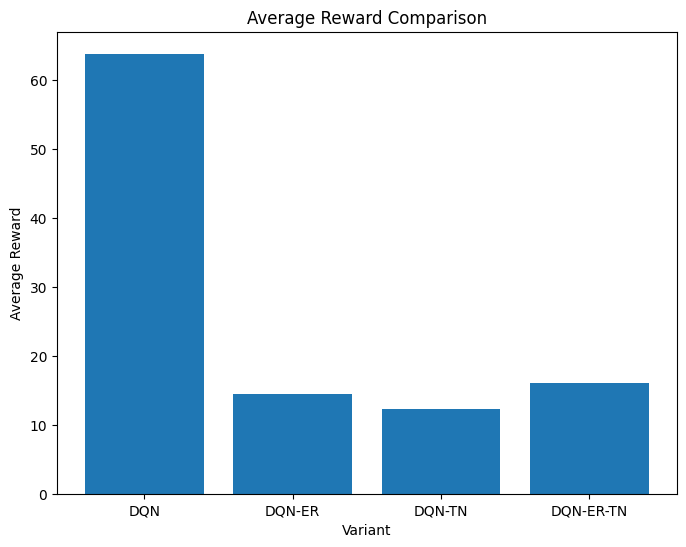

In [5]:
import matplotlib.pyplot as plt

# Episode times for each variant
dqn_times = [21, 11, 21, 38, 23, 23, 24, 32, 20, 45, 95, 116, 46, 89, 69, 133, 111, 86, 125, 148]
dqn_er_times = [21, 21, 17, 18, 13, 13, 13, 11, 16, 17, 13, 15, 11, 13, 12, 14, 12, 15, 11, 12]
dqn_tn_times = [24, 24, 12, 12, 13, 24, 13, 8, 12, 9, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10]
dqn_er_tn_times = [13, 21, 30, 32, 14, 17, 14, 11, 11, 11, 8, 22, 10, 15, 26, 25, 13, 10, 9, 9]

# Calculate average reward for each variant
dqn_avg_reward = sum(dqn_times) / len(dqn_times)
dqn_er_avg_reward = sum(dqn_er_times) / len(dqn_er_times)
dqn_tn_avg_reward = sum(dqn_tn_times) / len(dqn_tn_times)
dqn_er_tn_avg_reward = sum(dqn_er_tn_times) / len(dqn_er_tn_times)

# Plotting
plt.figure(figsize=(8, 6))

# Plotting average reward for each variant
plt.bar(['DQN', 'DQN-ER', 'DQN-TN', 'DQN-ER-TN'], [dqn_avg_reward, dqn_er_avg_reward, dqn_tn_avg_reward, dqn_er_tn_avg_reward])
plt.title('Average Reward Comparison')
plt.xlabel('Variant')
plt.ylabel('Average Reward')

plt.show()